#### This script is used to generate the metadata map of the collected GSV panorama in Tokyo
For Fig. 5 in the paper of Route4Shade PROJ

In [1]:
import os, os.path
from matplotlib import pyplot as plt

In [7]:
root = '/home/xiaojiang/xiaojiang/tokyo-proj/shibuya-proj'
seg_skyImg = os.path.join(root, 'gsv-images/tif-seg-panos')

# fields of GSV info
fields = ['pntNum', 'panoid', 'longitude', 'latitude', 'year', 'month', 'pano_yaw_degree']

# a list of GSV info dictionary
gsvInfoLst = []

# read the names of all processed files and then generate a gsv info list for creating shapefile
for skyImgFile in os.listdir(seg_skyImg):
    filename = os.path.splitext(skyImgFile)[0]
    metadata = filename.split(' - ')
    pntnum = metadata[0]
    panoid = metadata[1]
    lon = metadata[2]
    lat = metadata[3]
    year = metadata[4][:4]
    month = metadata[4][-2:]
    yaw = metadata[5][:-4]
    
    gsv_info = [pntnum, panoid, lon, lat, year, month, yaw]
    
    newEle = {fields[i]:gsv_info[i] for i in range(len(fields))} 
    gsvInfoLst.append(newEle)
    

In [4]:
len(gsvInfoLst)

45085

Create the shapefile based on the generated metadata

In [60]:

def CreatePointFeature_ogr(outputShapefile, gsvInfoLst):
    """
    Create a shapefile based on the template of inputShapefile
    This function will delete existing outpuShapefile and create a new
    
    Parameters:
      outputShapefile: the ouput shapefile name
      gsvInfoLst: the list of the metadata, lon and lat are included
    
    Examples:
    
    Copyright(c) Xiaojiang Li, MIT Senseable City Lab, June 22ed, 2017
    
    """
    
    import ogr
    import osr
    import re
    import os,os.path
    
    # create shapefile and add the above chosen random points to the shapfile
    driver = ogr.GetDriverByName("ESRI Shapefile")
    
    # create new shapefile
    if os.path.exists(outputShapefile):
        driver.DeleteDataSource(outputShapefile)
    data_source = driver.CreateDataSource(outputShapefile)
    
    targetSpatialRef = osr.SpatialReference()
    targetSpatialRef.ImportFromEPSG(4326)
    
    outLayer = data_source.CreateLayer(outputShapefile, targetSpatialRef, ogr.wkbPoint)
    
    numPnt = len(gsvInfoLst)
    print ('the number of points is:',numPnt)
    
    
    if numPnt > 0:
        # create fields
        fieldLst = gsvInfoLst[0].keys()
        
        for field in fieldLst:
            if field == 'pntNum' or field == 'year' or field == 'duration' or field == 'risedur' or field == 'setdur':
                outLayer.CreateField(ogr.FieldDefn(field, ogr.OFTInteger))
            elif field == 'pano_yaw_degree': #the name is too long
                outLayer.CreateField(ogr.FieldDefn("yaw", ogr.OFTReal))
            elif field == 'tilt_pitch_deg': #the name is too long
                outLayer.CreateField(ogr.FieldDefn("tilt", ogr.OFTReal))
            # elif field == 'longitude' or field == 'latitude':
            #     outLayer.CreateField(ogr.FieldDefn(field, ogr.OFTReal))
            else:
                fieldname = ogr.FieldDefn(field, ogr.OFTString)
                outLayer.CreateField(fieldname)
                
        
        for info in gsvInfoLst:
            #create point geometry
            point = ogr.Geometry(ogr.wkbPoint)
            
            # in case of the returned panoLon and PanoLat are invalid            
            if type(info["longitude"]) is str:
                if len(info["longitude"]) < 3:
                    continue
            
#             point.AddPoint(float(info["longitude"]),float(info["latitude"]))
            
            wkt = "POINT(%f %f)" %  (float(info["longitude"]) , float(info["latitude"]))
            point = ogr.CreateGeometryFromWkt(wkt)
            
            # Create the feature and set values
            featureDefn = outLayer.GetLayerDefn()
            outFeature = ogr.Feature(featureDefn)
            outFeature.SetGeometry(point)
            
            for field in fieldLst:
                # print ('The field name is ------------------:', field)

                if field == 'pntNum' or field == 'year':
                    outFeature.SetField(field, int(info[field]))
                elif field == 'pano_yaw_degree':
                    outFeature.SetField("yaw", float(info[field]))
                elif field == 'tilt_pitch_deg':
                    outFeature.SetField("tilt", float(info[field]))
                else:
                    # print ('The field is:', field, info[field])
                    outFeature.SetField(field, str(info[field]))
                
            outLayer.CreateFeature(outFeature)
            
            outFeature.Destroy()
        data_source.Destroy()
    else:
        print ('You create a empty shapefile')
    

In [61]:
## Generate the shapefile based on the metadata of the GSV
outputShapefile = os.path.join(root, 'GSV_metadata.shp')
CreatePointFeature_ogr(outputShapefile, gsvInfoLst)

the number of points is: 45085


#### Plot the histogram and other graphics of the time stamps of GSV info

In [8]:
## Plot the figure of the GSV metadata
monthList = []
yearList = []

for gsvInfo in gsvInfoLst:
    month = gsvInfo['month']
    year = gsvInfo['year']
    monthList.append(month)
    yearList.append(year)
    

In [9]:
len(monthList)

45085

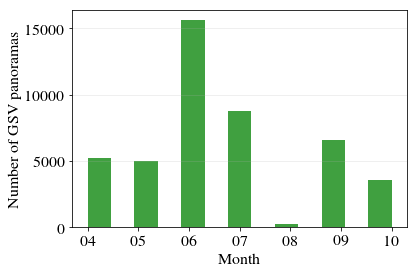

In [72]:
## The histogram of the month information of the GSV info
import numpy as np
from matplotlib import rc
import matplotlib.pyplot as mpl


rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
mpl.rcParams['font.size'] = 16


monthArray = np.asarray(monthList)
plt.hist(monthArray, bins = 13, color='green', alpha=0.75, rwidth=1)
plt.grid(axis='y', alpha=0.25)
plt.xlabel('Month')
plt.ylabel('Number of GSV panoramas')
plt.show()


Prepare the month data

In [73]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import collections

data = """
Jan
Feb
Mar
Apr
May
Jun
Jul
Aug
Sep
Oct
Nov
Dec
"""

months = data.split()

c = collections.Counter(monthList)
c = sorted(c.items())
month_names = [i[0] for i in c]
freq = [i[1] for i in c]

print(c)
print(months)
print(freq)


[('04', 5261), ('05', 5038), ('06', 15624), ('07', 8736), ('08', 234), ('09', 6604), ('10', 3588)]
['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
[5261, 5038, 15624, 8736, 234, 6604, 3588]


Prepare the yearly data

In [74]:
years = collections.Counter(yearList)
years= sorted(years.items())
# month_names = ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']
yearname = [i[0] for i in years]
yearfreq = [i[1] for i in years]

print(yearfreq)
print()
print(years)

[6884, 121, 183, 1586, 16017, 5959, 2170, 2136, 3664, 6365]

[('2009', 6884), ('2010', 121), ('2011', 183), ('2012', 1586), ('2013', 16017), ('2014', 5959), ('2015', 2170), ('2016', 2136), ('2017', 3664), ('2018', 6365)]


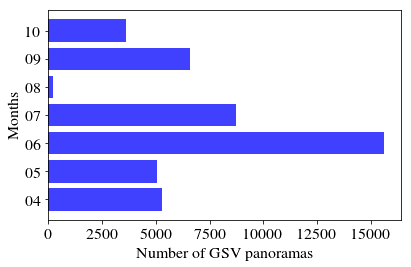

In [96]:
from matplotlib import gridspec

fig = plt.subplots(1,2, figsize=(15, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 3])

plt.subplot(gs[0])
plt.barh(month_names, freq, color='blue', alpha=0.75)
# plt.title("Job Request per month")
plt.xlabel("Number of GSV panoramas")
plt.ylabel("Months")
# ax.set_xticks(range(1, 13))
# ax.set_xticklabels(months)

# plt.subplot(gs[1])
# plt.barh(yearname, yearfreq, color='green', alpha=0.75)
# plt.xlabel('Number of GSV panoramas')
# plt.ylabel('Year')

plt.tight_layout()
plt.savefig('month_info.png', dpi=300)
plt.show()


In [68]:
fig

(<matplotlib.figure.Figure at 0x7fcdc98048d0>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcdc9804fd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fcdc9275898>], dtype=object))